In [1]:
import pickle
from pathlib import Path
from pprint import pp

import os
import sys

import h5py
import holodeck as holo
from holodeck.gps import gp_utils as gu
from holodeck.gps import plotting_utils as pu
from holodeck.gps import sam_utils as su

import matplotlib.pyplot as plt
import numpy as np
import corner

from holodeck.gps.gp_utils import GaussProc

# fixes relative-pathing errors for some GPs
from holodeck.gps import gp_utils 
sys.modules['gp_utils'] = gp_utils

%load_ext autoreload
%autoreload 2

## define notebook-wide variables here

In [2]:
# spectra and GPs

# the name of the spectrum libraries used to train and test the GPs
spectra_name_train = "broad-uniform-04_n600_r1k"
spectra_name_test = "broad-uniform-04_n1k_r1k"
# these are the date/time-based codes we use to distinguish GPs
gp_ext_means = "20230429_024952"
gp_ext_stdevs = "20230428_223544"

In [3]:
# plotting/visualization control
train_hist = False # if set to true, will display histograms of predictions made on the training data in the train/test comparison. Often very narrow/on a different scale from test hist.
save_figures = False # if set to true, will automatically save each of the figures created below using a prescribed filenaming convention
box_frac = 0.2 #sets the size of the %error box placed on figures. Default of 0.2 corresponds to 20%.

## definitions of helper functions

In [4]:
def get_mean_stdev(spectra,
                 gp_george,
                 gp_list,
                 gp_george_stdev,
                 gp_list_stdev,
                 xobs,
                 scale_factor=1.0, #1.0 for hc^2, 0.5 for hc
                 include_gp_unc = False):
    
    pts = (xobs.shape[0],len(gp_george))
    means = np.zeros(pts)
    stdevs = np.zeros(pts)
    
    for ind in range(pts[0]):
        env_param = xobs[ind,:].copy()
        hc, rho, rho_pred = gu.hc_from_gp(gp_george, gp_list, gp_george_stdev, gp_list_stdev, env_param, include_gp_unc=include_gp_unc)
        means[ind] = rho*scale_factor
        stdevs[ind] = rho_pred[:,1]*scale_factor
        
    return means,stdevs



def fraction_within_error(array,error_bound=0.1):
    return np.count_nonzero(np.abs(10**(np.ravel(array))-1)<error_bound)/(array.size)

## set up your directory and GPs of interest

In [5]:
spectra_file_train = Path(
    f"./spec_libraries/{spectra_name_train}/sam_lib.hdf5"
)
print_name_train = spectra_name_train.replace("broad-","b").replace("uniform-","u")
spectra_train = h5py.File(spectra_file_train, "r")

spectra_file_test = Path(
    f"./spec_libraries/{spectra_name_test}/sam_lib.hdf5"
)
print_name_test = spectra_name_test.replace("broad-","b").replace("uniform-","u")
spectra_test = h5py.File(spectra_file_test, "r")

In [6]:
gaussproc = GaussProc  # For backwards compatibility before change to camel-case

# load the trained GPs and set up predictions

# means
gp_file_means = "trained_gp_" + spectra_file_train.parent.name + "_" + gp_ext_means + ".pkl"
with open(spectra_file_train.parent / gp_file_means, "rb") as f:
    gp_george_means = pickle.load(f)
gp_means = gu.set_up_predictions(spectra_train, gp_george_means)

# standard deviations
gp_file_stdevs = "trained_gp_" + spectra_file_train.parent.name + "_" + gp_ext_stdevs + ".pkl"
with open(spectra_file_train.parent / gp_file_stdevs, "rb") as f:
    gp_george_stdevs = pickle.load(f)
gp_stdevs = gu.set_up_predictions(spectra_train, gp_george_stdevs)

## recover means and stdevs

In [7]:
# first, get gwb information

# for training data
_, xobs_train, yerr_train, yobs_train, yobs_mean_train = gu.get_gwb(spectra_train, len(gp_george_means))
yobs_train += yobs_mean_train
# for testing data
_, xobs_test, yerr_test, yobs_test, yobs_mean_test = gu.get_gwb(spectra_test, len(gp_george_means))
yobs_test += yobs_mean_test

Found 0.00e+00/6.00e+02 = 0.00e+00 samples with NaN entries.  Removing them from library.
setting aside 0.0 of samples (0) for testing, and choosing 14 frequencies
Found 3.00e+00/1.00e+03 = 3.00e-03 samples with NaN entries.  Removing them from library.
setting aside 0.0 of samples (0) for testing, and choosing 14 frequencies


In [8]:
# then, find training and test set predictions for mean and stdevs
# note that this step can take many seconds, depending on your hardware and the size of the spectrum library you're using
# for very large libraries, you may want to consider pickling the recovered means and stdevs to easily load them later
m_train,s_train = get_mean_stdev(spectra_train,gp_george_means,gp_means,gp_george_stdevs,gp_stdevs,xobs_train)
m_test,s_test = get_mean_stdev(spectra_test,gp_george_means,gp_means,gp_george_stdevs,gp_stdevs,xobs_test)

## look at training data response

In [9]:
yobs_train_plot = np.ravel(yobs_train)
m_train_plot = np.ravel(m_train)
yerr_train_plot = np.ravel(yerr_train)
s_train_plot = np.ravel(s_train)

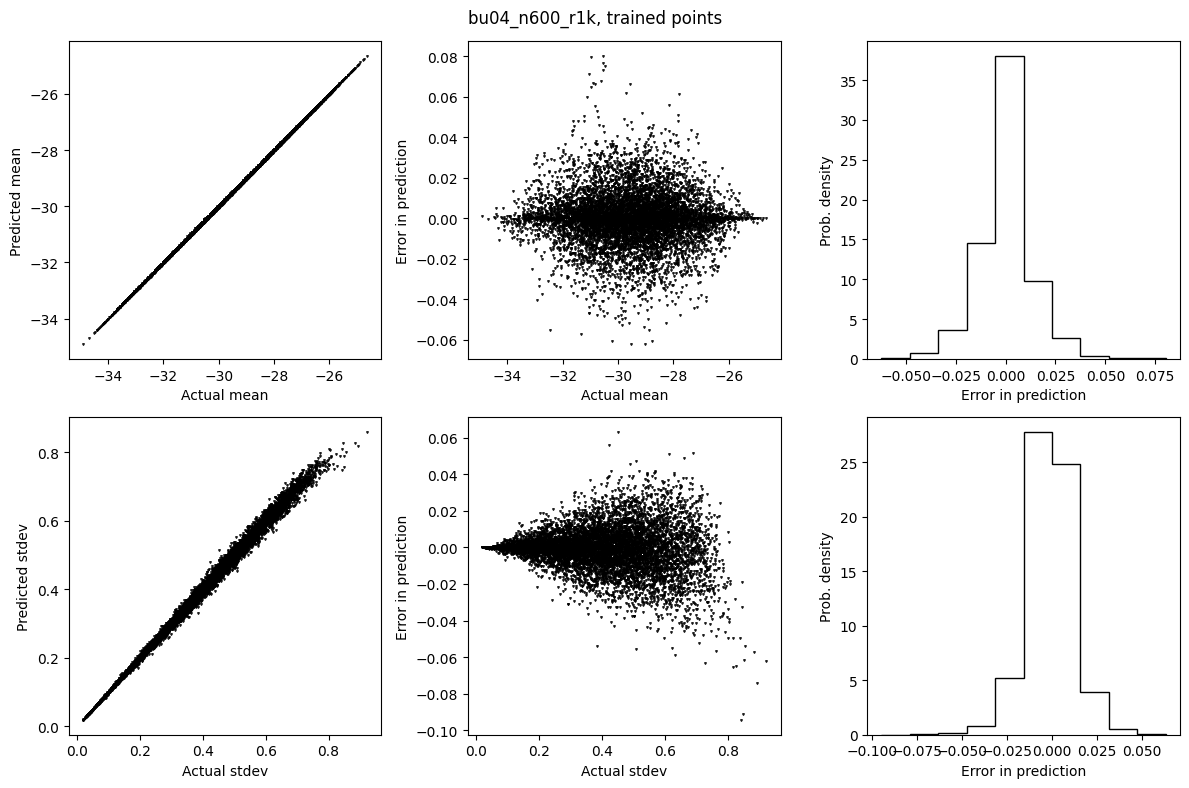

In [10]:
fig,ax = plt.subplots(ncols=3,nrows=2)
ptsize = 1

ax[0,0].scatter(yobs_train_plot,m_train_plot,s=ptsize,marker='v',c='black')
ax[0,0].set_xlabel("Actual mean")
ax[0,0].set_ylabel("Predicted mean")

ax[0,1].scatter(yobs_train_plot,m_train_plot-yobs_train_plot,s=ptsize,marker='v',c='black')
ax[0,1].set_xlabel("Actual mean")
ax[0,1].set_ylabel("Error in prediction")

ax[0,2].hist(m_train_plot-yobs_train_plot,density=True,histtype='step',color='black')
ax[0,2].set_xlabel("Error in prediction")
ax[0,2].set_ylabel("Prob. density")

ax[1,0].scatter(yerr_train_plot,s_train_plot,s=ptsize,marker='v',c='black')     
ax[1,0].set_xlabel("Actual stdev")
ax[1,0].set_ylabel("Predicted stdev")

ax[1,1].scatter(yerr_train_plot,s_train_plot-yerr_train_plot,s=ptsize,marker='v',c='black')
ax[1,1].set_xlabel("Actual stdev")
ax[1,1].set_ylabel("Error in prediction")

ax[1,2].hist(s_train_plot-yerr_train_plot,density=True,histtype='step',color='black')
ax[1,2].set_xlabel("Error in prediction")
ax[1,2].set_ylabel("Prob. density")


fig.suptitle(f"{print_name_train}, trained points")
fig.set_size_inches(12,8)
fig.tight_layout()

if save_figures:
    plt.savefig(f"{print_name_train}-confirmation_means-stdevs_{ext_m}+{ext_v}.png")

## look at test data response, c.f. training

In [11]:
yobs_test_plot = np.ravel(yobs_test)
m_test_plot = np.ravel(m_test)
yerr_test_plot = np.ravel(yerr_test)
s_test_plot = np.ravel(s_test)

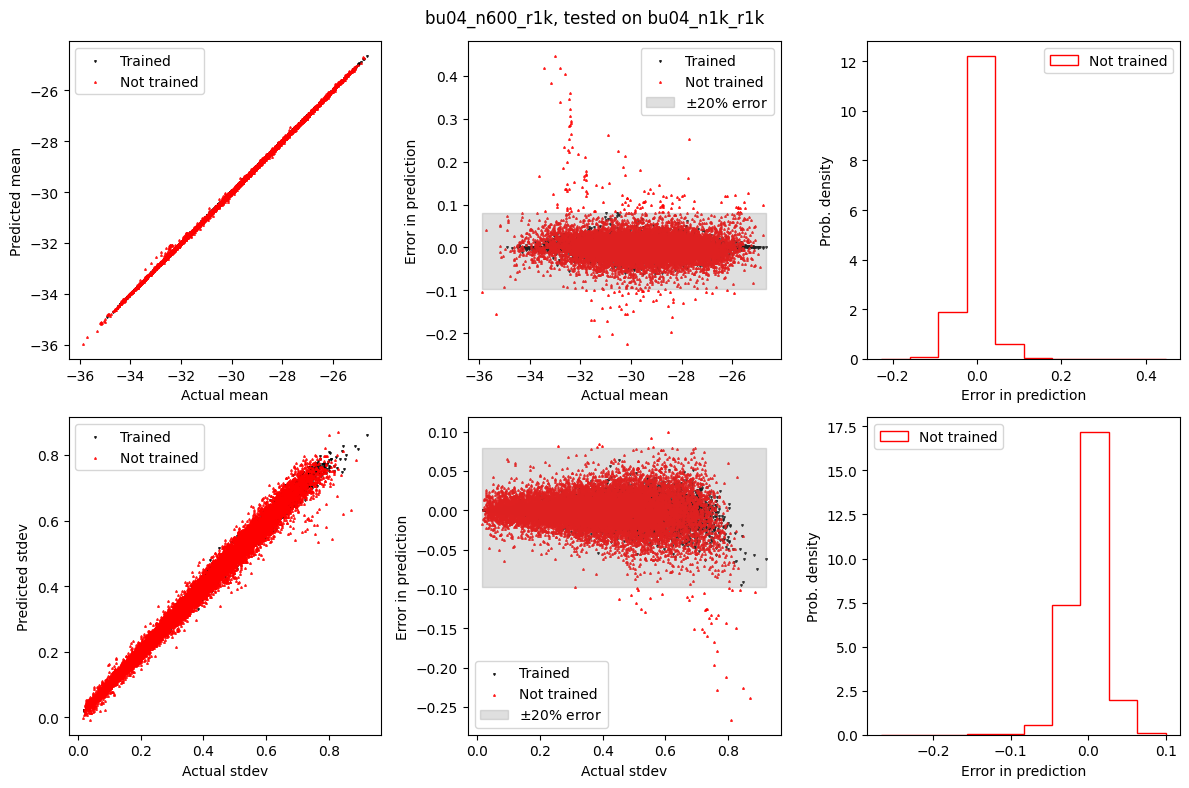

In [12]:
fig,ax = plt.subplots(ncols=3,nrows=2)
ptsize = 1

ax[0,0].scatter(yobs_train_plot,m_train_plot,s=ptsize,marker='v',c='black',label="Trained")
ax[0,0].scatter(yobs_test_plot,m_test_plot,s=ptsize,marker='^',c='red',label="Not trained")
ax[0,0].legend()
ax[0,0].set_xlabel("Actual mean")
ax[0,0].set_ylabel("Predicted mean")

ax[0,1].scatter(yobs_train_plot,m_train_plot-yobs_train_plot,s=ptsize,marker='v',c='black',label="Trained")
ax[0,1].scatter(yobs_test_plot,m_test_plot-yobs_test_plot,s=ptsize,marker='^',c='red',label="Not trained")
if box_frac > 0.0:
    ax[0,1].fill_between([np.min([np.min(yobs_train),np.min(yobs_test)]),np.max([np.max(yobs_train),np.max(yobs_test)])],
                         np.log10(1-box_frac),np.log10(1+box_frac),color='gray',alpha=0.25, label=r"$\pm20\%$ error")
ax[0,1].legend()
ax[0,1].set_xlabel("Actual mean")
ax[0,1].set_ylabel("Error in prediction")

if train_hist:
    ax[0,2].hist(m_train_plot-yobs_train_plot,density=True,histtype='step',color='black',label="Trained")
ax[0,2].hist(m_test_plot-yobs_test_plot,density=True,histtype='step',color='red',label="Not trained")
ax[0,2].legend()
ax[0,2].set_xlabel("Error in prediction")
ax[0,2].set_ylabel("Prob. density")

ax[1,0].scatter(yerr_train_plot,s_train_plot,s=ptsize,marker='v',c='black',label="Trained")
ax[1,0].scatter(yerr_test_plot,s_test_plot,s=ptsize,marker='^',c='red',label="Not trained")
ax[1,0].legend()
ax[1,0].set_xlabel("Actual stdev")
ax[1,0].set_ylabel("Predicted stdev")

ax[1,1].scatter(yerr_train_plot,s_train_plot-yerr_train_plot,s=ptsize,marker='v',c='black',label="Trained")
ax[1,1].scatter(yerr_test_plot,s_test_plot-yerr_test_plot,s=ptsize,marker='^',c='red',label="Not trained")
if box_frac > 0.0:
    ax[1,1].fill_between([np.min([np.min(yerr_train),np.min(yerr_test)]),np.max([np.max(yerr_train),np.max(yerr_test)])],
                         np.log10(1-box_frac),np.log10(1+box_frac),color='gray',alpha=0.25, label=r"$\pm20\%$ error")
ax[1,1].legend()
ax[1,1].set_xlabel("Actual stdev")
ax[1,1].set_ylabel("Error in prediction")

if train_hist:
    ax[1,2].hist(s_train_plot-yerr_train_plot,density=True,histtype='step',color='black',label="Trained")
ax[1,2].hist(s_test_plot-yerr_test_plot,density=True,histtype='step',color='red',label="Not trained")
ax[1,2].legend()
ax[1,2].set_xlabel("Error in prediction")
ax[1,2].set_ylabel("Prob. density")



fig.suptitle(f"{print_name_train}, tested on {print_name_test}")
fig.set_size_inches(12,8)
fig.tight_layout()

if save_figures:
    plt.savefig(f"{print_name_train}-vs-{print_name_test}_means-stdevs_{ext_m}+{ext_v}.png")

In [13]:
# print out some fractions w/in errors
print(f"Untrained means, fraction within {box_frac:.1%}: {fraction_within_error(m_test-yobs_test,box_frac):3f}")
print(f"Untrained stdevs, fraction within {box_frac:.1%}: {fraction_within_error(s_test-yerr_test,box_frac):3f}")

Untrained means, fraction within 20.0%: 0.986674
Untrained stdevs, fraction within 20.0%: 0.996489
